## Importing The Required Libraries

In [1]:
# Filter warnings
import warnings
warnings.filterwarnings(action="ignore")
# Progress Bar
from tqdm.auto import tqdm
tqdm.pandas()

# Tabulate and random utilities
from tabulate import tabulate
import random
import os


# Data Preprocessing
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import pearsonr, spearmanr

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from sklearn.preprocessing import StandardScaler, RobustScaler
import optuna
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# ML Explainability
#import shap
#shap.initjs()

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["DSN_FUTMINNA"] = str(seed)  # Ensure deterministic hashing

set_seed(2025)

In [3]:
train_df = pd.read_csv("train.csv") 
test_df = pd.read_csv("test.csv")

## Exploratory Data Analysis

In [4]:
##Data Types and shape
print("Dataset Shape:", train_df.shape)
print("\
Column Names and Types:")
print(train_df.dtypes)
print("\
First few rows:")
train_df.head()

Dataset Shape: (7307, 9)
Column Names and Types:
ID               object
Temperature     float64
Humidity        float64
MQ7_analog      float64
MQ9_analog      float64
MG811_analog    float64
MQ135_analog    float64
device_name      object
CO2             float64
dtype: object
First few rows:


,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name,CO2
0,ID_000001,28.975,74.475,2480.0,3476.5,1572.0,1997.0,alpha,585.75
1,ID_000002,31.900,66.500,3813.0,2726.0,4145.0,3180.0,alpha,613.00
2,ID_000003,31.675,60.015,2811.0,1563.5,4250.0,2708.5,alpha,616.50
3,ID_000004,31.580,59.220,2844.0,1597.0,4310.0,2723.0,alpha,642.50
4,ID_000005,31.690,62.030,3159.5,1120.5,5519.5,1219.0,alpha,622.00


In [5]:
print("Test Data Shape:", test_df.shape)
print("\
Column Names and Types:")
print(test_df.dtypes)
print("\
First few rows:")
test_df.head()

Test Data Shape: (1292, 8)
Column Names and Types:
ID               object
Temperature     float64
Humidity        float64
MQ7_analog      float64
MQ9_analog      float64
MG811_analog    float64
MQ135_analog    float64
device_name      object
dtype: object
First few rows:


,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name
0,ID_007308,32.450,59.990,3504.0,1380.0,2642.5,1637.0,alpha
1,ID_007309,31.665,58.640,2864.0,1659.0,4456.0,3564.5,alpha
2,ID_007310,31.755,59.000,2850.5,1615.0,4391.0,2683.5,alpha
3,ID_007311,31.860,66.850,3853.5,2868.5,4170.5,3025.5,alpha
4,ID_007312,29.600,73.115,2506.5,3631.5,1481.5,2112.5,alpha


In [6]:
# Deep statistical overview and missing data analysis
print("=== COMPREHENSIVE DATA OVERVIEW ===")
print(f"Dataset contains {train_df.shape[0]} observations with {train_df.shape[1]} features")
print(f"Target variable: CO2 (continuous regression problem)")

=== COMPREHENSIVE DATA OVERVIEW ===
Dataset contains 7307 observations with 9 features
Target variable: CO2 (continuous regression problem)


In [7]:
# Deep statistical overview and missing data analysis
print("=== COMPREHENSIVE DATA OVERVIEW ===")
print(f"Test Data contains {test_df.shape[0]} observations with {test_df.shape[1]} features")

=== COMPREHENSIVE DATA OVERVIEW ===
Test Data contains 1292 observations with 8 features


In [8]:
print("\
=== MISSING DATA ANALYSIS ===")
missing_data = train_df.isnull().sum()
missing_percent = (missing_data / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)
print(missing_df)

=== MISSING DATA ANALYSIS ===
              Missing_Count  Missing_Percentage
ID                        0                 0.0
Temperature               0                 0.0
Humidity                  0                 0.0
MQ7_analog                0                 0.0
MQ9_analog                0                 0.0
MG811_analog              0                 0.0
MQ135_analog              0                 0.0
device_name               0                 0.0
CO2                       0                 0.0


In [9]:
print("\
=== MISSING DATA ANALYSIS IN TEST SET ===")
missing_data = test_df.isnull().sum()
missing_percent = (missing_data / len(test_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)
print(missing_df)

=== MISSING DATA ANALYSIS IN TEST SET ===
              Missing_Count  Missing_Percentage
ID                        0                 0.0
Temperature               0                 0.0
Humidity                  0                 0.0
MQ7_analog                0                 0.0
MQ9_analog                0                 0.0
MG811_analog              0                 0.0
MQ135_analog              0                 0.0
device_name               0                 0.0


In [10]:
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

In [11]:
print("=== STATISTICAL SUMMARY ===")
train_df.describe()

=== STATISTICAL SUMMARY ===


,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2
count,7307.000000,7307.000000,7307.000000,7307.000000,7307.000000,7307.000000,7307.000000
mean,29.681726,69.593742,4230.820902,3976.708841,3995.126568,3444.788240,611.634608
std,2.016785,7.248136,1085.008100,1603.972744,1098.740604,893.426679,16.540953
min,23.440000,52.200000,2380.000000,1098.500000,1353.500000,1186.500000,573.166667
25%,28.490000,65.665000,3362.500000,2832.500000,3181.000000,2912.500000,600.000000
50%,29.290000,70.555000,4061.000000,4073.000000,4137.000000,3586.500000,608.000000
75%,31.717500,74.350000,4780.750000,5286.166667,4731.000000,4143.750000,621.000000
max,33.850000,93.525000,9545.500000,10379.500000,7919.000000,6257.000000,677.000000


### Insights

In [12]:
##CHeck the unique value within each column 

print("\
=== UNIQUE VALUES ANALYSIS ===")
for col in train_df.columns:
    unique_count = train_df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count < 20:  # Show unique values for categorical-like columns
        print(f"  Values: {sorted(train_df[col].unique())}")
    print()

=== UNIQUE VALUES ANALYSIS ===
ID: 7307 unique values

Temperature: 1728 unique values

Humidity: 3860 unique values

MQ7_analog: 4211 unique values

MQ9_analog: 4392 unique values

MG811_analog: 4006 unique values

MQ135_analog: 3617 unique values

device_name: 3 unique values
  Values: ['alpha', 'beta', 'charlie']

CO2: 310 unique values



## Data Visualization

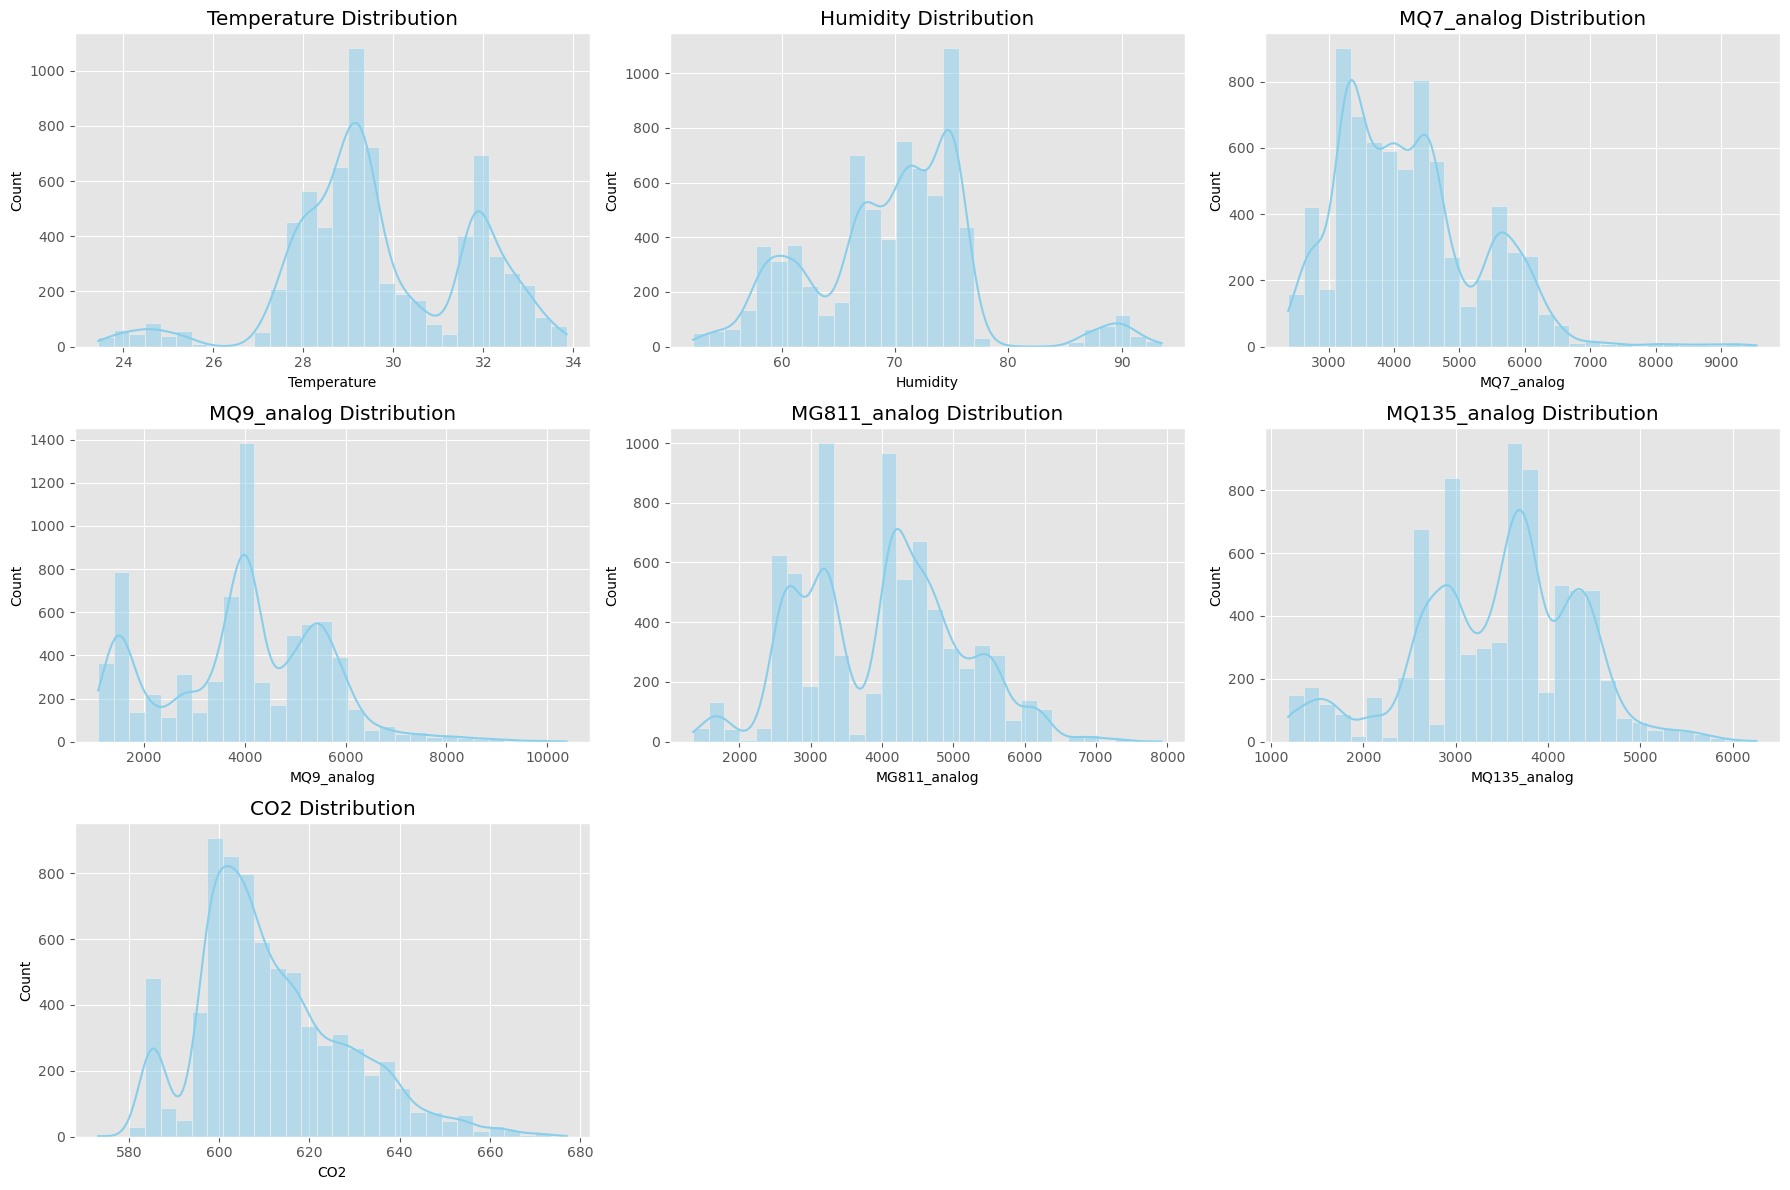

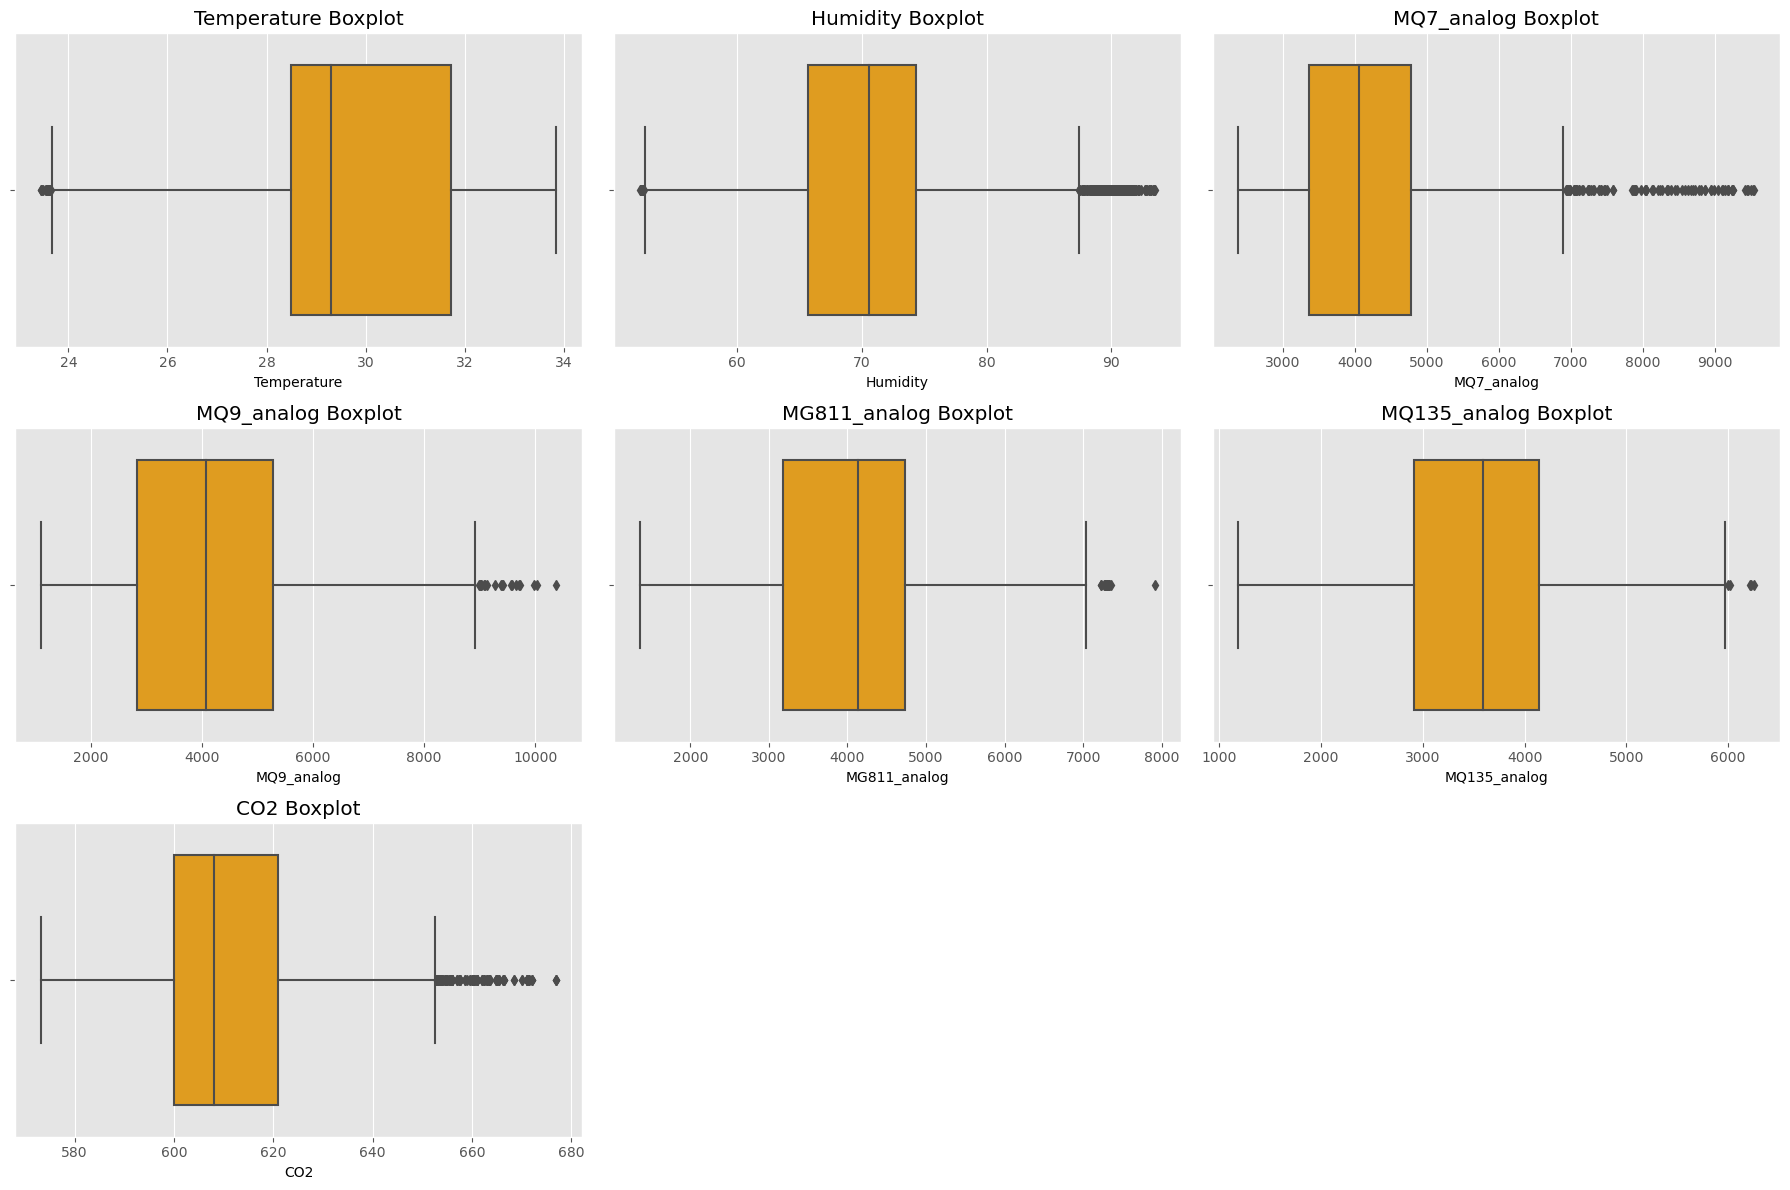

In [13]:
# Visualize distributions and outliers for all numeric features
num_cols = ['Temperature', 'Humidity', 'MQ7_analog', 'MQ9_analog', 'MG811_analog', 'MQ135_analog', 'CO2']

plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_df[col], kde=True, bins=30, color='skyblue')
    plt.title(col + ' Distribution')
plt.tight_layout()
plt.show()

# Boxplots for outlier detection
plt.figure(figsize=(18, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x= train_df[col], color='orange')
    plt.title(col + ' Boxplot')
plt.tight_layout()
plt.show()

In [14]:
# Advanced correlation analysis and feature relationships
print("=== CORRELATION MATRIX ANALYSIS ===")
correlation_matrix = train_df[num_cols].corr()
print("Correlation with CO2 target:")
co2_correlations = correlation_matrix['CO2'].sort_values(ascending=False)
print(co2_correlations)


=== CORRELATION MATRIX ANALYSIS ===
Correlation with CO2 target:
CO2             1.000000
MG811_analog    0.101462
MQ7_analog      0.093732
MQ135_analog    0.027344
MQ9_analog     -0.026366
Humidity       -0.032440
Temperature    -0.050370
Name: CO2, dtype: float64


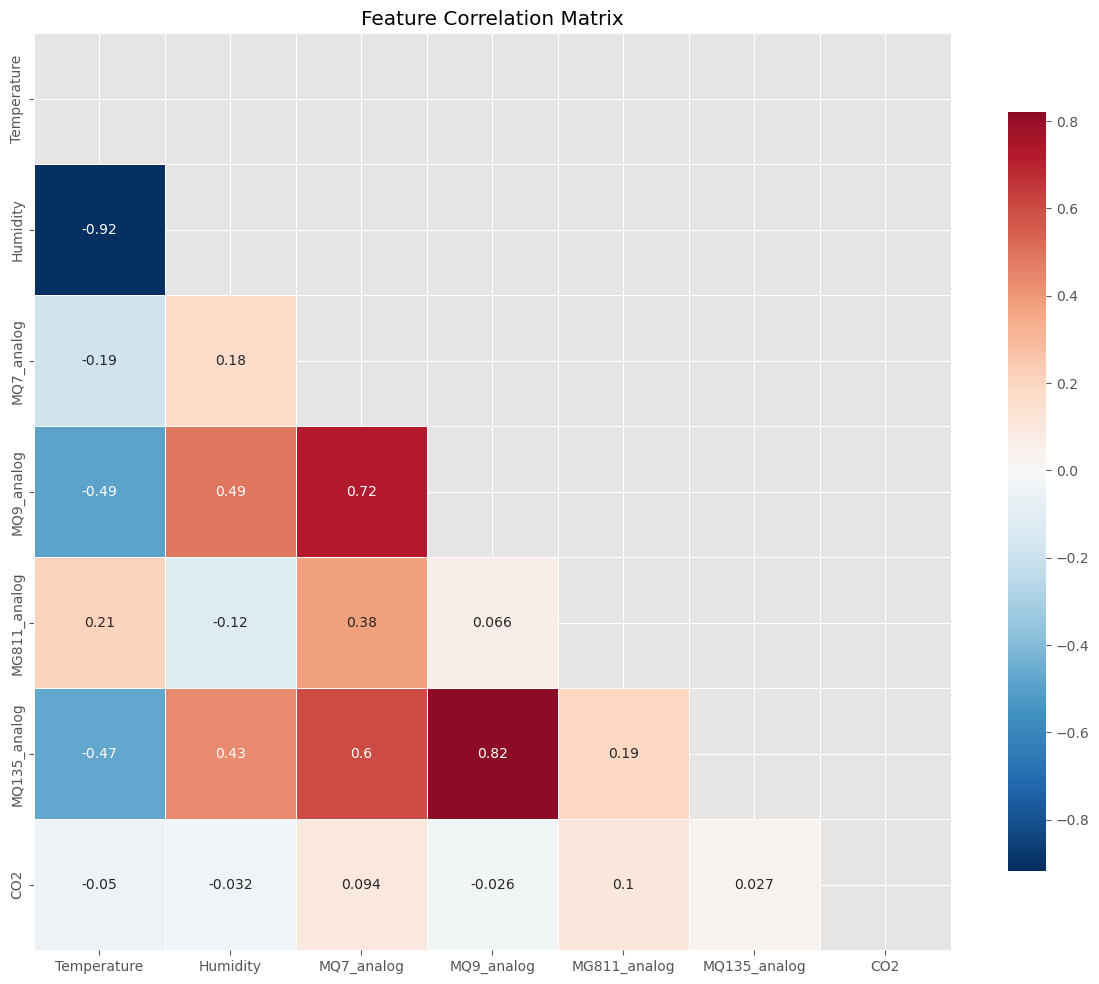

In [15]:
# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [16]:
# Statistical significance of correlations with CO2
print("\
=== CORRELATION SIGNIFICANCE TESTS ===")
for col in num_cols[:-1]:  # Exclude CO2 itself
    corr_coef, p_value = pearsonr(train_df[col], train_df['CO2'])
    spearman_coef, spearman_p = spearmanr(train_df[col], train_df['CO2'])
    print(f"{col}:")
    print(f"  Pearson: r={corr_coef:.4f}, p={p_value:.2e}")
    print(f"  Spearman: ρ={spearman_coef:.4f}, p={spearman_p:.2e}")
    print()

=== CORRELATION SIGNIFICANCE TESTS ===
Temperature:
  Pearson: r=-0.0504, p=1.65e-05
  Spearman: ρ=-0.1433, p=7.90e-35

Humidity:
  Pearson: r=-0.0324, p=5.55e-03
  Spearman: ρ=0.0452, p=1.10e-04

MQ7_analog:
  Pearson: r=0.0937, p=9.86e-16
  Spearman: ρ=0.0845, p=4.69e-13

MQ9_analog:
  Pearson: r=-0.0264, p=2.42e-02
  Spearman: ρ=-0.0351, p=2.68e-03

MG811_analog:
  Pearson: r=0.1015, p=3.50e-18
  Spearman: ρ=0.0807, p=4.91e-12

MQ135_analog:
  Pearson: r=0.0273, p=1.94e-02
  Spearman: ρ=0.0505, p=1.59e-05



In [17]:
# Analyze device_name impact and feature-target relationships
print("=== DEVICE-SPECIFIC ANALYSIS ===")
device_stats = train_df.groupby('device_name')['CO2'].agg(['count', 'mean', 'std', 'min', 'max'])
print("CO2 statistics by device:")
print(device_stats)


=== DEVICE-SPECIFIC ANALYSIS ===
CO2 statistics by device:
             count        mean        std         min    max
device_name                                                 
alpha         2391  611.297140  16.346132  573.166667  677.0
beta          2485  611.744592  16.528877  573.166667  677.0
charlie       2431  611.854097  16.744119  573.166667  677.0


Text(0.5, 1.0, 'CO2 Distribution by Device')

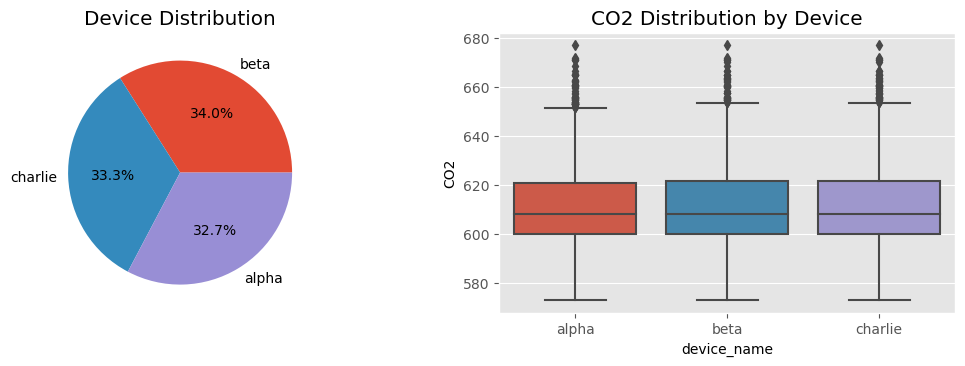

In [18]:
# Visualize device differences
plt.figure(figsize=(20, 8))
# Device distribution
plt.subplot(2, 3, 1)
device_counts = train_df['device_name'].value_counts()
plt.pie(device_counts.values, labels=device_counts.index, autopct='%1.1f%%')
plt.title('Device Distribution')


# CO2 by device
plt.subplot(2, 3, 2)
sns.boxplot(data= train_df, x='device_name', y='CO2')
plt.title('CO2 Distribution by Device')
#plt.xticks(rotation=45)

In [19]:
# Sensor interaction patterns
print("\
=== SENSOR INTERACTION ANALYSIS ===")
sensor_cols = ['MQ7_analog', 'MQ9_analog', 'MG811_analog', 'MQ135_analog']
for i in range(len(sensor_cols)):
    for j in range(i+1, len(sensor_cols)):
        corr = train_df[sensor_cols[i]].corr(train_df[sensor_cols[j]])
        print(f"{sensor_cols[i]} vs {sensor_cols[j]}: r={corr:.4f}")

=== SENSOR INTERACTION ANALYSIS ===
MQ7_analog vs MQ9_analog: r=0.7234
MQ7_analog vs MG811_analog: r=0.3781
MQ7_analog vs MQ135_analog: r=0.6023
MQ9_analog vs MG811_analog: r=0.0663
MQ9_analog vs MQ135_analog: r=0.8200
MG811_analog vs MQ135_analog: r=0.1931


In [20]:
# Drop Train ID
train_df.drop("ID", axis=1, inplace=True)
# Store Test ID
test_id = pd.DataFrame(test_df.pop("ID"))

In [21]:
total_df = pd.concat([train_df, test_df], axis=0) #Combined train and test dataset

print(f"Total shape: {total_df.shape}")

total_df.head()

Total shape: (8599, 8)


,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name,CO2
0,28.975,74.475,2480.0,3476.5,1572.0,1997.0,alpha,585.75
1,31.900,66.500,3813.0,2726.0,4145.0,3180.0,alpha,613.00
2,31.675,60.015,2811.0,1563.5,4250.0,2708.5,alpha,616.50
3,31.580,59.220,2844.0,1597.0,4310.0,2723.0,alpha,642.50
4,31.690,62.030,3159.5,1120.5,5519.5,1219.0,alpha,622.00


In [22]:
enc_total_df = pd.get_dummies(total_df, columns=["device_name"], dtype=np.int64)

enc_total_df.head()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2,device_name_alpha,device_name_beta,device_name_charlie
0,28.975,74.475,2480.0,3476.5,1572.0,1997.0,585.75,1,0,0
1,31.900,66.500,3813.0,2726.0,4145.0,3180.0,613.00,1,0,0
2,31.675,60.015,2811.0,1563.5,4250.0,2708.5,616.50,1,0,0
3,31.580,59.220,2844.0,1597.0,4310.0,2723.0,642.50,1,0,0
4,31.690,62.030,3159.5,1120.5,5519.5,1219.0,622.00,1,0,0


In [23]:
log_trans_df = enc_total_df.copy()

for i in enc_total_df.columns[:-4]:
    log_trans_df[i] = np.log10(1+ log_trans_df[i]) #Apply log transform for the features

In [24]:
#data_spliting

train =log_trans_df.iloc[:train_df.shape[0]]
X = train.drop(columns = ['CO2'])
y = train['CO2']


def scaling(data):
    scaler = RobustScaler()
    for col in X.columns:
        data[col] = scaler.fit_transform(data[[col]])
    return data

X = scaling(X)

X_train,X_test, y_train, y_test = train_test_split(X, y , test_size = .25, random_state = 2025)

### Baeline Models

In [28]:


models = {
 #   "Linear Regression" : LinearRegression(),
    "Extra_Tree" : ExtraTreesRegressor(random_state=2025),
    "random_forest" : RandomForestRegressor(random_state=2025,),# **params),
    "catboost" : CatBoostRegressor(random_state=2025, verbose = False),
    "lightgbm" : LGBMRegressor(random_state=2025, verbosity = -1),
    "xgboost" : XGBRegressor( verbose = False,)
}



list_r2 = []
list_mae = []
list_rmse = []
model_list = []

for name, model in models.items():
    print(f"Training {name}")
    model.fit(X_train, (y_train) )
    y_pred = model.predict(X_test) 
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt (mean_squared_error(y_test, y_pred) )
    
    list_r2.append(r2)
    list_mae.append(mae)
    list_rmse.append(rmse)
    model_list.append(name)
    print(f"Done")
    
result_baseline = pd.DataFrame({"r2_score" : list_r2,
                      "mea_score" : list_mae,
                      "rmse" : list_rmse} ,index= model_list)    

Training Extra_Tree
Done
Training random_forest
Done
Training catboost
Done
Training lightgbm
Done
Training xgboost
Done


In [29]:
result_baseline

,r2_score,mea_score,rmse
Extra_Tree,0.897571,2.866933,5.175010
random_forest,0.886550,3.092871,5.446301
catboost,0.863361,3.798913,5.977056
lightgbm,0.846489,3.979862,6.335343
xgboost,0.860996,3.593165,6.028561


## Feature Engineering

In [30]:
def FeatureInteraction(df, col):
    new_features = pd.DataFrame()

    for f1, f2 in combinations(col, 2):
        # Multiply features
        new_features[f'{f1}_x_{f2}'] = df[f1] * df[f2]

        # Divide features (skip division by 0)
        new_features[f'{f1}_div_{f2}'] = np.where(df[f2] != 0, df[f1] / df[f2], np.nan)
        new_features[f'{f2}_div_{f1}'] = np.where(df[f1] != 0, df[f2] / df[f1], np.nan)

        # Add features
        new_features[f'{f1}_plus_{f2}'] = df[f1] + df[f2]

        # Subtract features (both directions)
        new_features[f'{f1}_minus_{f2}'] = df[f1] - df[f2]
        new_features[f'{f2}_minus_{f1}'] = df[f2] - df[f1]

    # Optionally, you can add back the original features to the dataframe
    df_with_new_features = pd.concat([df, new_features], axis=1)

    return df_with_new_features

def SND_Feature(df, col):
    new_df = pd.DataFrame()

    for f1, f2 in combinations(col, 2):
        new_df[f"SND_{f1}_{f2}"] = (df[f1] - df[f2])/df[f1] + df[f2]

    df_with_new_features = pd.concat([df, new_df], axis=1)

    return df_with_new_features

In [31]:
exp_df = FeatureInteraction(log_trans_df, ["MQ7_analog","MQ9_analog","MG811_analog","MQ135_analog"])
extra_feature = SND_Feature(exp_df, ["Temperature", "Humidity", "MQ7_analog", "MQ9_analog", "MG811_analog", "MQ135_analog"])

extra_feature.head()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2,device_name_alpha,device_name_beta,device_name_charlie,...,SND_Humidity_MQ7_analog,SND_Humidity_MQ9_analog,SND_Humidity_MG811_analog,SND_Humidity_MQ135_analog,SND_MQ7_analog_MQ9_analog,SND_MQ7_analog_MG811_analog,SND_MQ7_analog_MQ135_analog,SND_MQ9_analog_MG811_analog,SND_MQ9_analog_MQ135_analog,SND_MG811_analog_MQ135_analog
0,1.476759,1.877803,3.394627,3.541267,3.196729,3.300595,585.75,1,0,0,...,2.586862,2.655411,2.494352,2.542906,3.498069,3.255026,3.328296,3.294021,3.368558,3.268104
1,1.517196,1.829304,3.581381,3.435685,3.617629,3.502564,613.00,1,0,0,...,2.623597,2.557547,2.640030,2.587866,3.476367,3.607508,3.524571,3.564672,3.483098,3.534371
2,1.514216,1.785437,3.449015,3.194376,3.628491,3.432889,616.50,1,0,0,...,2.517266,2.405247,2.596220,2.510172,3.268205,3.576454,3.437565,3.492591,3.358222,3.486796
3,1.512951,1.779741,3.454082,3.203577,3.634578,3.435207,642.50,1,0,0,...,2.513304,2.403552,2.592383,2.505034,3.276101,3.582322,3.440672,3.500041,3.362903,3.490061
4,1.514415,1.799547,3.499756,3.049799,3.741978,3.086360,622.00,1,0,0,...,2.554958,2.355040,2.662579,2.371284,3.178367,3.672767,3.204481,3.515019,3.074372,3.261566


In [32]:
trainX = extra_feature.iloc[:train_df.shape[0]]#.drop("CO2", axis=1)
X_ = trainX.drop(columns = ['CO2'])
y_  = trainX['CO2']
testX = extra_feature.iloc[train_df.shape[0]:].drop("CO2", axis=1)

## Features Scaling

In [33]:
def scaling(data):
    scaler = RobustScaler()
    for col in testX.columns:
        data[col] = scaler.fit_transform(data[[col]])
    return data

X_ = scaling(X_)
testX = scaling(testX)

## Models Optimization

In [40]:
##Lighgbm Regressor

def objective_lgbm(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),  # Avoid too fast learning
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),  # Too large = overfit
        "max_depth": trial.suggest_int("max_depth", 3, 12),  # Control complexity
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),  # Avoid small noisy splits
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),  # Bagging
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),  # L1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),  # L2
        "random_state": 42,
        "n_jobs": -1
    }

    model = LGBMRegressor(**params)

    cv = KFold(n_splits= 5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_, y_, cv=cv, scoring="neg_root_mean_squared_error").mean()
    return -score


study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)

[I 2025-05-31 00:35:25,275] A new study created in memory with name: no-name-0305a21d-17ae-4526-8a48-2f607060777c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 00:35:45,109] Trial 0 finished with value: 5.969039385095341 and parameters: {'n_estimators': 732, 'learning_rate': 0.021489009495906885, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.7117428114777914, 'colsample_bytree': 0.561214787495687, 'reg_alpha': 1.5065066343548696, 'reg_lambda': 0.009845847832383337}. Best is trial 0 with value: 5.969039385095341.
[I 2025-05-31 00:35:59,541] Trial 1 finished with value: 5.988614710903706 and parameters: {'n_estimators': 806, 'learning_rate': 0.044360871192770504, 'num_leaves': 37, 'max_depth': 6, 'min_child_samples': 67, 'subsample': 0.707163597700966, 'colsample_bytree': 0.5515229119152932, 'reg_alpha': 0.005739461766638439, 'reg_lambda': 1.5742152362294908}. Best is trial 0 with value: 5.969039385095341.
[I 2025-05-31 00:36:40,458] Trial 2 finished with value: 6.071037753721514 and parameters: {'n_estimators': 822, 'learning_rate': 0.00791665587952997, 'num_leaves': 29, 'max_depth': 10, 'min_child_sam

[I 2025-05-31 00:49:16,997] Trial 21 finished with value: 5.144905224375768 and parameters: {'n_estimators': 644, 'learning_rate': 0.09393814744890991, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.8361598010144964, 'colsample_bytree': 0.8925506634623294, 'reg_alpha': 9.855400790267083, 'reg_lambda': 0.06737710191156716}. Best is trial 21 with value: 5.144905224375768.
[I 2025-05-31 00:49:59,817] Trial 22 finished with value: 5.199215963134136 and parameters: {'n_estimators': 563, 'learning_rate': 0.06099871832513242, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 18, 'subsample': 0.8308992602517378, 'colsample_bytree': 0.8512612373448722, 'reg_alpha': 6.027472733663278, 'reg_lambda': 0.06281842060408294}. Best is trial 21 with value: 5.144905224375768.
[I 2025-05-31 00:50:39,627] Trial 23 finished with value: 5.267206930102334 and parameters: {'n_estimators': 675, 'learning_rate': 0.09366392641849798, 'num_leaves': 75, 'max_depth': 11, 'min_child_

[I 2025-05-31 01:05:19,159] Trial 42 finished with value: 5.168935653332636 and parameters: {'n_estimators': 611, 'learning_rate': 0.09247477416934069, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.8753953427202621, 'colsample_bytree': 0.8719235914963398, 'reg_alpha': 9.922343761848126, 'reg_lambda': 0.18762312718161783}. Best is trial 21 with value: 5.144905224375768.
[I 2025-05-31 01:05:56,840] Trial 43 finished with value: 5.328892102004977 and parameters: {'n_estimators': 590, 'learning_rate': 0.05392784504521359, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8694276945301737, 'colsample_bytree': 0.5146338888305172, 'reg_alpha': 6.261440692268738, 'reg_lambda': 0.19213265271045532}. Best is trial 21 with value: 5.144905224375768.
[I 2025-05-31 01:07:15,068] Trial 44 finished with value: 5.231112139980958 and parameters: {'n_estimators': 614, 'learning_rate': 0.09946017702843092, 'num_leaves': 95, 'max_depth': 11, 'min_child_

In [41]:
print("Best LightGBM  params:", study_lgbm.best_params)
print("Best LightGBM RMSE:", study_lgbm.best_value)

Best LightGBM  params: {'n_estimators': 644, 'learning_rate': 0.09393814744890991, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.8361598010144964, 'colsample_bytree': 0.8925506634623294, 'reg_alpha': 9.855400790267083, 'reg_lambda': 0.06737710191156716}
Best LightGBM RMSE: 5.144905224375768


In [42]:
#Extra Trees Optimization
def objective_extratree(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 5, 30),  # Too high can overfit
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 20),  # Avoid tiny splits
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),  # Avoid overfitting leaves
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),  # Avoid full features
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = ExtraTreesRegressor(**params)

    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    score = cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error").mean()
    return -score

study_et = optuna.create_study(direction="minimize")
study_et.optimize(objective_extratree, n_trials=50, show_progress_bar=True)

[I 2025-05-31 01:12:50,414] A new study created in memory with name: no-name-e464afa7-4cdc-44a7-bfb0-f8b6c550f699


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 01:13:03,769] Trial 0 finished with value: 9.1643823670247 and parameters: {'n_estimators': 493, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 9.1643823670247.
[I 2025-05-31 01:13:09,863] Trial 1 finished with value: 10.051003304548022 and parameters: {'n_estimators': 296, 'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 9.1643823670247.
[I 2025-05-31 01:13:32,475] Trial 2 finished with value: 8.688986943540407 and parameters: {'n_estimators': 885, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 8.688986943540407.
[I 2025-05-31 01:13:43,176] Trial 3 finished with value: 9.107606453891247 and parameters: {'n_estimators': 503, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'l

[I 2025-05-31 01:22:11,578] Trial 31 finished with value: 6.466121139581759 and parameters: {'n_estimators': 990, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 23 with value: 6.032794962027621.
[I 2025-05-31 01:22:41,447] Trial 32 finished with value: 6.240793426913257 and parameters: {'n_estimators': 929, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 23 with value: 6.032794962027621.
[I 2025-05-31 01:23:13,538] Trial 33 finished with value: 7.177950636716142 and parameters: {'n_estimators': 943, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 23 with value: 6.032794962027621.
[I 2025-05-31 01:23:56,277] Trial 34 finished with value: 6.876424823527543 and parameters: {'n_estimators': 845, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_

In [45]:
print("Best ExtraTrees params:", study_et.best_params)
print("Best ExtraTree RMSE:", study_et.best_value)

Best ExtraTrees params: {'n_estimators': 1000, 'max_depth': 24, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}
Best ExtraTree RMSE: 6.032794962027621


In [43]:
def objective_catboost(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),  # slow learning prevents overfit
        "depth": trial.suggest_int("depth", 4, 10),  # deeper trees can overfit
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),  # L2 regularization
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),  # 0 = no randomness, >0 adds noise
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "rsm": trial.suggest_float("rsm", 0.5, 0.95),  # feature sampling
        "loss_function": "RMSE",
        "verbose": 0,
        "random_state": 42
    }

    model = CatBoostRegressor(**params)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error").mean()
    return -score

study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_catboost, n_trials=50, show_progress_bar=True)


[I 2025-05-31 01:35:27,424] A new study created in memory with name: no-name-fee3489b-cb9b-41be-89a0-90ebc50a192a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-31 01:36:16,085] Trial 0 finished with value: 9.700590992678352 and parameters: {'iterations': 818, 'learning_rate': 0.007042316898680943, 'depth': 7, 'l2_leaf_reg': 8.673775356428765, 'bagging_temperature': 0.997076217231051, 'random_strength': 5.572636617643555, 'rsm': 0.8427302609539667}. Best is trial 0 with value: 9.700590992678352.
[I 2025-05-31 01:36:32,124] Trial 1 finished with value: 6.955645761562299 and parameters: {'iterations': 640, 'learning_rate': 0.08095556791376421, 'depth': 4, 'l2_leaf_reg': 8.971032936460166, 'bagging_temperature': 0.9017128936902685, 'random_strength': 0.0020775279603437087, 'rsm': 0.8130353861554158}. Best is trial 1 with value: 6.955645761562299.
[I 2025-05-31 01:36:52,808] Trial 2 finished with value: 10.523532844042755 and parameters: {'iterations': 692, 'learning_rate': 0.005471456064535823, 'depth': 5, 'l2_leaf_reg': 3.6273863948757104, 'bagging_temperature': 0.1487276755774568, 'random_strength': 0.33044787254133634, 'rsm': 0.8977

[I 2025-05-31 02:04:16,148] Trial 24 finished with value: 6.290255172057003 and parameters: {'iterations': 610, 'learning_rate': 0.03685424409409448, 'depth': 9, 'l2_leaf_reg': 5.637855100292712, 'bagging_temperature': 0.7564126592495046, 'random_strength': 0.008907464651411954, 'rsm': 0.5677478237708193}. Best is trial 11 with value: 5.713432929614938.
[I 2025-05-31 02:05:44,564] Trial 25 finished with value: 5.905636347313313 and parameters: {'iterations': 478, 'learning_rate': 0.0649418274456099, 'depth': 10, 'l2_leaf_reg': 3.3287573276950138, 'bagging_temperature': 0.6001772663944173, 'random_strength': 0.0025735811775198735, 'rsm': 0.8322932130613404}. Best is trial 11 with value: 5.713432929614938.
[I 2025-05-31 02:06:13,622] Trial 26 finished with value: 7.928374432252295 and parameters: {'iterations': 312, 'learning_rate': 0.0194091563560407, 'depth': 8, 'l2_leaf_reg': 4.739912080994806, 'bagging_temperature': 0.27634453579575335, 'random_strength': 0.003502963389378678, 'rsm':

[I 2025-05-31 02:35:25,535] Trial 47 finished with value: 7.066745226146777 and parameters: {'iterations': 849, 'learning_rate': 0.04281171738269561, 'depth': 4, 'l2_leaf_reg': 1.0318409850619976, 'bagging_temperature': 0.848285571915655, 'random_strength': 0.21552878811973344, 'rsm': 0.6394058978286394}. Best is trial 42 with value: 5.549579288485587.
[I 2025-05-31 02:36:34,710] Trial 48 finished with value: 5.672859288639332 and parameters: {'iterations': 938, 'learning_rate': 0.05500992211102555, 'depth': 9, 'l2_leaf_reg': 2.208685558913038, 'bagging_temperature': 0.9381399627622949, 'random_strength': 0.030976770402701064, 'rsm': 0.6903698438217651}. Best is trial 42 with value: 5.549579288485587.
[I 2025-05-31 02:37:36,296] Trial 49 finished with value: 5.998265316396268 and parameters: {'iterations': 921, 'learning_rate': 0.02986528944688717, 'depth': 9, 'l2_leaf_reg': 2.2769547086224913, 'bagging_temperature': 0.9447142056291495, 'random_strength': 0.037023934098831694, 'rsm': 0

In [44]:
print("Best CatBoost params:", study_cat.best_params)
print("Best CatBoost RMSE:", study_cat.best_value)

Best CatBoost params: {'iterations': 893, 'learning_rate': 0.07670466645031877, 'depth': 10, 'l2_leaf_reg': 1.8482897778096932, 'bagging_temperature': 0.8318246622609728, 'random_strength': 0.0023132857402351713, 'rsm': 0.5814926116658846}
Best CatBoost RMSE: 5.549579288485587


In [ ]:
XGBRegressor Hyperparameter Tuning

from xgboost import XGBRegressor

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),  # regularization to avoid overfit
        "gamma": trial.suggest_float("gamma", 0, 5),  # pruning
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),  # L1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),  # L2
        "objective": "reg:squarederror",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error").mean()
    return -score

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)





In [ ]:
print("Best XGB params:", study_xgb.best_params)
print("Best XGB RMSE:", study_xgb.best_value)

### Result after Optimization with optuna

In [47]:
def TrainFold(X, y, Xtest, algos, cv= 10, shuffle=False, random_state=2025):
    kfcv = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state) if shuffle else KFold(n_splits=cv)

    test_pred = {"model_name":[], "pred":[]}
    trained_models = {}

    for algo in algos:
        init_algo = algo(verbosity=0) if (algo.__name__ == "XGBRegressor") else \
                    algo if (algo.__name__ == "RandomForestRegressor") else \
                    algo(verbose=0) if (algo.__name__ == "CatBoostRegressor") else \
                    algo(verbose=-1) if (algo.__name__ == "LGBMRegressor") else \
                    algo(verbose = -1) if (algo.__name__ == "RandomForestRegressor") else \
                    algo()

        pred_per_fold = { "val":[], "test":[]}#"train":[],
        score_per_fold = {#"train_rmse": [], #"train_mae": [] , #"train_r2"   [], : 
             "val_rmse": [],
            "val_mae": [],
             "val_r2": []
        }

        for fold, (train_idx, val_idx) in tqdm(enumerate(kfcv.split(X, y), start=1), desc=f"Training {algo.__name__}", total=cv):
            xtrain, ytrain = X.iloc[train_idx], y.iloc[train_idx]
            xtest, yval = X.iloc[val_idx], y.iloc[val_idx]

            init_algo.fit(xtrain, ytrain)

            for i, j, target in zip([ "val"], [xtrain, xtest], [ytrain, yval]):#"train"
                pred = init_algo.predict(j)
                pred_per_fold[i].append(pred)
                score_per_fold[f"{i}_rmse"].append(np.sqrt(mean_squared_error(target, pred)))
                score_per_fold[f"{i}_mae"].append(mean_absolute_error(target, pred))
                score_per_fold[f"{i}_r2"].append(r2_score(target, pred))

            pred_per_fold["test"].append(init_algo.predict(Xtest))

        # Store trained model
        trained_models[algo.__name__] = init_algo

        # Print RMSE, MAE, and R² scores using tabulate
        score_table = [
            [fold+1,
            # score_per_fold["train_rmse"][fold], 
             score_per_fold["val_rmse"][fold],
            # score_per_fold["train_mae"][fold],
             score_per_fold["val_mae"][fold],
            # score_per_fold["train_r2"][fold], 
            score_per_fold["val_r2"][fold] ]
            for fold in range(cv)
        ]

        score_table.append([
            "Average",
          #  np.mean(score_per_fold["train_rmse"]),  "Train RMSE", 
            np.mean(score_per_fold["val_rmse"]),
            #np.mean(score_per_fold["train_mae"]),  "Train MAE",
            np.mean(score_per_fold["val_mae"]),
            #np.mean(score_per_fold["train_r2"]), "Train R²",
            np.mean(score_per_fold["val_r2" ]) #"Val R²"])
        ])

        print(f"\nScores for {algo.__name__} (Per fold):\n")
        print(tabulate(score_table, headers=["Fold", "Val RMSE",  "Val MAE", "Val R²" ], tablefmt="grid"))

        test_pred["model_name"].extend([algo.__name__]*len(Xtest))
        test_pred["pred"].extend(np.mean(pred_per_fold["test"], axis=0))

    return pd.DataFrame(test_pred), trained_models


In [48]:
trainX = extra_feature.iloc[:train_df.shape[0]].drop("CO2", axis=1)
testX = extra_feature.iloc[train_df.shape[0]:].drop("CO2", axis=1)

In [49]:
test_pred, train_model = TrainFold(trainX,
                                   total_df[:train_df.shape[0]]["CO2"],
                                   testX,
                                   [LGBMRegressor,XGBRegressor,ExtraTreesRegressor]) #list of models

Training LGBMRegressor:   0%|          | 0/10 [00:00<?, ?it/s]


Scores for LGBMRegressor (Per fold):

+---------+------------+-----------+----------+
| Fold    |   Val RMSE |   Val MAE |   Val R² |
+=========+============+===========+==========+
| 1       |    3.99614 |   2.7623  | 0.942111 |
+---------+------------+-----------+----------+
| 2       |    3.96009 |   2.72824 | 0.942765 |
+---------+------------+-----------+----------+
| 3       |    3.95548 |   2.73884 | 0.942607 |
+---------+------------+-----------+----------+
| 4       |    3.97728 |   2.74078 | 0.942764 |
+---------+------------+-----------+----------+
| 5       |    3.95776 |   2.7157  | 0.942367 |
+---------+------------+-----------+----------+
| 6       |    3.94318 |   2.72449 | 0.943332 |
+---------+------------+-----------+----------+
| 7       |    3.97643 |   2.73344 | 0.941999 |
+---------+------------+-----------+----------+
| 8       |    3.90548 |   2.65407 | 0.944066 |
+---------+------------+-----------+----------+
| 9       |    3.87751 |   2.64591 | 0.945276 |
+

Training XGBRegressor:   0%|          | 0/10 [00:00<?, ?it/s]


Scores for XGBRegressor (Per fold):

+---------+------------+-----------+----------+
| Fold    |   Val RMSE |   Val MAE |   Val R² |
+=========+============+===========+==========+
| 1       |    1.97565 |   1.43798 | 0.985851 |
+---------+------------+-----------+----------+
| 2       |    1.95624 |   1.43441 | 0.986033 |
+---------+------------+-----------+----------+
| 3       |    1.97142 |   1.4351  | 0.985743 |
+---------+------------+-----------+----------+
| 4       |    1.97918 |   1.44595 | 0.985827 |
+---------+------------+-----------+----------+
| 5       |    1.91153 |   1.39068 | 0.986556 |
+---------+------------+-----------+----------+
| 6       |    1.94419 |   1.42484 | 0.986224 |
+---------+------------+-----------+----------+
| 7       |    1.87902 |   1.37167 | 0.987049 |
+---------+------------+-----------+----------+
| 8       |    1.96472 |   1.42093 | 0.985844 |
+---------+------------+-----------+----------+
| 9       |    1.91539 |   1.40098 | 0.986647 |
+-

Training ExtraTreesRegressor:   0%|          | 0/10 [00:00<?, ?it/s]


Scores for ExtraTreesRegressor (Per fold):

+---------+-------------+-------------+----------+
| Fold    |    Val RMSE |     Val MAE |   Val R² |
+=========+=============+=============+==========+
| 1       | 0.000435988 | 2.28102e-05 |        1 |
+---------+-------------+-------------+----------+
| 2       | 0.000692109 | 3.49757e-05 |        1 |
+---------+-------------+-------------+----------+
| 3       | 0.000380085 | 1.97689e-05 |        1 |
+---------+-------------+-------------+----------+
| 4       | 0.00034879  | 1.52068e-05 |        1 |
+---------+-------------+-------------+----------+
| 5       | 0.00130893  | 4.05515e-05 |        1 |
+---------+-------------+-------------+----------+
| 6       | 0.0004776   | 2.28102e-05 |        1 |
+---------+-------------+-------------+----------+
| 7       | 0.000261593 | 9.12409e-06 |        1 |
+---------+-------------+-------------+----------+
| 8       | 0.00080386  | 3.19295e-05 |        1 |
+---------+-------------+------------

In [50]:
for i in ["ExtraTreesRegressor"]:
    test_id["CO2"] = test_pred[test_pred["model_name"] == i].drop("model_name", axis=1).reset_index(drop=True)
    test_id.to_csv(f"{i}_10fold_best_model_indaba_dsn_futminna_test_zindi_score.csv", index=False)
    test_id.drop("CO2", axis=1, inplace=True)